In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_val_predict, StratifiedKFold, KFold
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

In [6]:
score = pd.read_csv('LBLS467-data/score.csv')
srl_motivation = pd.read_csv('LBLS467-data/srl_motivation.csv')
sill = pd.read_csv('LBLS467-data/sill.csv')
srl_strategy = pd.read_csv('LBLS467-data/srl_strategy.csv')
br = pd.read_csv('LBLS467-data/br.csv')
viscode = pd.read_csv('LBLS467-data/viscode.csv')

In [7]:
br.head()

,Unnamed: 0,userid,ADD BOOKMARK,ADD MARKER,ADD MEMO,ADD_HW_MEMO,ADD_RECOMMENDATION,BOOKMARK_JUMP,CHANGE MEMO,CLEAR_HW_MEMO,...,OPEN,OPEN_RECOMMENDATION,PAGE_JUMP,PREV,REGIST CONTENTS,SEARCH,SEARCH_JUMP,UNDO_HW_MEMO,score,class
0,0,019acd030e0cdf674dda03e2a8ca4369,1,81,15,0,0,0,14,0,...,159,0,109,1584,0,0,0,0,70,h
1,1,01ea38c4c3cc5fba869732fc641ca884,7,354,36,1,0,2,22,1,...,256,0,67,750,0,1,0,2,80,a
2,2,023c88ec58c8cf0abcfbcea4166793ad,1,61,25,0,0,0,9,0,...,325,0,7,1275,0,0,0,0,90,a
3,3,02d679ad650962b6ae8bf8adbeeb33c1,4,188,28,8,0,4,25,0,...,138,0,40,788,0,0,0,0,56,c
4,4,0307ea84b89fceab3b507fec1900ce7e,43,464,48,1,0,116,214,0,...,415,0,80,2771,0,0,0,1,80,b


In [8]:
from functools import reduce

dfs = [score, srl_motivation, sill, srl_strategy, br]

def merge_keep_left(left, right):
    right = right[[col for col in right.columns if col not in left.columns or col == "userid"]]
    return pd.merge(left, right, on="userid", how="inner")

merged = reduce(merge_keep_left, dfs)


In [114]:
merged.columns

Index(['userid', 'score', 'class', 'srl_m_1', 'srl_m_2', 'srl_m_3', 'srl_m_4',
       'srl_m_5', 'srl_m_6', 'srl_m_7',
       ...
       'NEXT', 'NOTGETIT', 'OPEN', 'OPEN_RECOMMENDATION', 'PAGE_JUMP', 'PREV',
       'REGIST CONTENTS', 'SEARCH', 'SEARCH_JUMP', 'UNDO_HW_MEMO'],
      dtype='object', length=159)

In [9]:
len(merged)

204

In [10]:
X = merged.drop(["userid","class","score",'Unnamed: 0'], axis=1)  
y = merged["score"]

In [11]:
merged.corr(numeric_only=True)["score"].sort_values(ascending=False)

score                 1.000000
srl_m_19              0.425210
srl_m_23              0.396347
srl_m_24              0.356284
srl_m_22              0.354662
                        ...   
s_44                 -0.202610
srl_m_30             -0.228294
srl_m_27             -0.286955
ADD_RECOMMENDATION         NaN
REGIST CONTENTS            NaN
Name: score, Length: 157, dtype: float64

In [12]:
from sklearn.model_selection import cross_val_score
rf = RandomForestRegressor(n_estimators=200, random_state=42)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
all_preds = np.zeros(len(y))
rmse_list = []
feature_importances = []
for train_idx, val_idx in cv.split(X):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            model = RandomForestRegressor(n_estimators=200, random_state=42)
            model.fit(X_train, y_train)

            y_pred = model.predict(X_val)
            all_preds[val_idx] = y_pred

            rmse = rmse = np.sqrt(mean_squared_error(y_val, y_pred))
            rmse_list.append(rmse)
            feature_importances.append(model.feature_importances_)

print("Cross-validation RMSE scores:", rmse_list)
print("Mean RMSE:", np.mean(rmse_list))


Cross-validation RMSE scores: [np.float64(7.5408888248198345), np.float64(9.408205811171747), np.float64(11.061085406317666), np.float64(11.327863957042752), np.float64(8.271810072469027)]
Mean RMSE: 9.521970814364204


In [17]:
feature_importances = np.array(feature_importances)
mean_importance = feature_importances.mean(axis=0)
std_importance = feature_importances.std(axis=0)

feat_imp_cv = pd.DataFrame({
    "Feature": X.columns,
    "MeanImportance": mean_importance,
    "StdImportance": std_importance
}).sort_values("MeanImportance", ascending=False)

print(feat_imp_cv)

# # Plot
# plt.figure(figsize=(10,6))
# plt.barh(feat_imp_cv["Feature"], feat_imp_cv["MeanImportance"],
#          xerr=feat_imp_cv["StdImportance"])
# plt.gca().invert_yaxis()
# plt.xlabel("Mean Feature Importance (±1 std)")
# plt.title("Random Forest Feature Importance (Cross-Validation)")
# plt.show()


                 Feature  MeanImportance  StdImportance
22              srl_m_23        0.087671       0.021431
18              srl_m_19        0.081374       0.058591
137                CLOSE        0.049505       0.015876
135          CHANGE MEMO        0.038344       0.012388
149            PAGE_JUMP        0.026662       0.009318
..                   ...             ...            ...
136        CLEAR_HW_MEMO        0.000505       0.000240
148  OPEN_RECOMMENDATION        0.000015       0.000030
143           LINK_CLICK        0.000005       0.000008
133   ADD_RECOMMENDATION        0.000000       0.000000
151      REGIST CONTENTS        0.000000       0.000000

[155 rows x 3 columns]


## Nudging Iteration

### With double For-loop

In [14]:
def nudging_iteration(X, y, X_states, n_rounds=5, n_splits=5):
    """
    Run iterative nudging simulation.
    - X: Training features
    - X_states: DataFrame with Skill, Motivation, Fatigue
    - y: ground truth labels
    - n_rounds: number of iterations
    - n_splits: number of CV splits for baseline prediction
    """
    current_y = y.copy()
    results = []
    
    for t in range(n_rounds):
        # baseline prediction with CV
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        all_preds = np.zeros(len(current_y))
        rmses = []
        for train_idx, val_idx in kf.split(X):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = current_y.iloc[train_idx], current_y.iloc[val_idx]

            rf = RandomForestRegressor(n_estimators=200, random_state=42)
            rf.fit(X_train, y_train)

            y_pred_val = rf.predict(X_val)
            all_preds[val_idx] = y_pred_val

            # RMSE
            mse = mean_squared_error(y_val, y_pred_val)
            rmses.append(np.sqrt(mse))

        residuals = current_y.values - all_preds
        sigma = np.std(residuals)
        mean_rmse = np.mean(rmses)

        # fit linear regression to estimate f(features)
        X_fit = pd.DataFrame({
        "Intrinsic": X_states["Intrinsic"].values,
        "Metacognitive": X_states["Metacognitive"].values,
        "Task_value": X_states["Task_value"].values,
        "Test_anxiety": X_states["Test_anxiety"].values,  
        }, index=X_states.index)
    
        reg = LinearRegression()
        reg.fit(X_fit, current_y)

        X_pred = X_fit.copy()
        f_values = reg.predict(X_pred)
        f_centered = f_values - f_values.mean()
        
        # do(N)
        do_N = np.random.normal(loc=f_centered, scale=sigma)
        
        # nudge rating
        direction = np.sign(all_preds - current_y)  # directional nudging
        do_N = np.abs(do_N) * direction
        nudge_rating = current_y + do_N
        # nudge_rating = np.clip(np.round(nudge_rating), 1, 4)

        current_y = pd.Series(nudge_rating, index=y.index)

        # distances
        results.append({
            "round": t+1,
            "cv_rmse": mean_rmse,
            "mean_dist_nudge": np.mean(np.abs(current_y - all_preds)),
            "mean_dist_true": np.mean(np.abs(y - all_preds)),
            "mean_current_y": current_y.mean(),
            "mean_all_preds": all_preds.mean()
        })
        
        print(f"[Round {t+1}] CV RMSE={mean_rmse:.4f}, "
              f"mean nudged_y={current_y.mean():.3f}, "
              f"dist to preds={np.mean(np.abs(current_y - all_preds)):.4f}")
        
        # save the final model if needed
        final_model = RandomForestRegressor(n_estimators=200, random_state=42)
        final_model.fit(X, current_y)

    return results, current_y, final_model

### With cross-val-predict

In [156]:
pd.DataFrame(y_hat).describe()

,0
count,204.000000
mean,83.892157
std,1.426313
min,82.385882
25%,83.226101
50%,83.586195
75%,84.246367
max,98.590108


In [155]:
pd.DataFrame(y).describe()

,score
count,204.000000
mean,83.892157
std,10.732674
min,38.000000
25%,79.750000
50%,86.000000
75%,91.000000
max,99.000000


In [ ]:
def pca_weighted_score(scaled_df, features):
    """
    use PCA to determine weights for given features and compute a weighted score
    """
    
    pca = PCA(n_components=1)
    pca.fit(scaled_df[features])
    
    # use absolute values of loadings as weights
    loadings = np.abs(pca.components_[0])
    weights = loadings / loadings.sum()
    
    # calculate weighted score
    scores = scaled_df[features].values @ weights
    return scores * 100, dict(zip(features, weights))

def init_states(df):
    """
    Calculate features parameters: Intrinsic, Test Anxiety, Task Value, Metacognitive
    """
    # # Intrinsic proxies
    # intrinsic_features = ["srl_m_1", "srl_m_2", "srl_m_3", 
    #                   "srl_m_4"]
    
    # # Metacognitive proxies
    # metacognitive_features = ["s_28", "s_29", "s_30", 
    #                   "s_31", "s_32", "s_33", "s_34", "s_35", "s_36"]
    
    # # Task Value proxies
    # task_value_features = ["srl_m_9", "srl_m_10", "srl_m_11",
    #                   "srl_m_12", "srl_m_13", "srl_m_14"]
    
    # Test Anxiety proxies
    test_anxiety_features = ["srl_m_27", "srl_m_28", "srl_m_29",
                      "srl_m_30", "srl_m_31"]
    
    all_features =  test_anxiety_features
    scaler = MinMaxScaler()
    scaled_all = scaler.fit_transform(df[all_features])
    scaled_df = pd.DataFrame(scaled_all, columns=all_features, index=df.index)
    
    # pca weighted scores for each parameter
    # intrinsic, intrinsic_w = pca_weighted_score(scaled_df, intrinsic_features)
    # metacognitive, metacognitive_w = pca_weighted_score(scaled_df, metacognitive_features)
    # task_value, task_value_w = pca_weighted_score(scaled_df, task_value_features)
    test_anxiety, test_anxiety_w = pca_weighted_score(scaled_df, test_anxiety_features)
    
    # return results and weights
    states = pd.DataFrame({
        # "Intrinsic": intrinsic,
        # "Metacognitive": metacognitive,
        # "Task_value": task_value,
        "Test_anxiety": test_anxiety
    }, index=df.index)
    
    weights = {
        # "Intrinsic": intrinsic_w,
        # "Metacognitive": metacognitive_w,
        # "Task_value": task_value_w,
        "Test_anxiety": test_anxiety_w
    }
    
    return states, weights

count    204.000000
mean       2.735294
std        1.100170
min        1.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        5.000000
Name: srl_m_27, dtype: float64

In [35]:
def single_nudging_iteration(X, y, X_states, n_rounds=5, n_splits=5, plot_each_round=False):
    """
    Run iterative nudging simulation.
    - X: Training features
    - X_states: DataFrame with Skill, Motivation, Fatigue
    - y: ground truth labels
    - n_rounds: number of iterations
    - n_splits: number of CV splits for baseline prediction
    """
    current_y = y.copy()
    results = []
    pred_history = []
    individual = []
    f_values_his = []
    nudged_history = []
    f_values_baseline = None
    
    for t in range(n_rounds):
        # baseline prediction with CV
        rf = RandomForestRegressor(n_estimators=200, random_state=42)
        all_preds = cross_val_predict(rf, X, current_y, cv=n_splits)
        pred_history.append(all_preds.copy())
        
        
        # CV RMSE
        mse = mean_squared_error(current_y, all_preds)
        mean_rmse = np.sqrt(mse)


        residuals = current_y.values - all_preds
        sigma = np.std(residuals)

        # fit linear regression to estimate f(features)
        X_fit = pd.DataFrame({
        "Test_anxiety": X_states["Test_anxiety"].values,  
        }, index=X_states.index)
    
        reg = LinearRegression()
        reg.fit(X_fit, current_y)

        X_pred = X_fit.copy()
        f_values = reg.predict(X_pred)
        if f_values_baseline is None:
            f_values_baseline = f_values.copy()
        f_centered = f_values - f_values.mean()
        f_values_his.append(f_values.copy())
        
        # do(N)
        do_N = np.random.normal(loc=f_centered, scale=0.5)
        
        # nudge rating
        direction = np.sign(all_preds - current_y)  # directional nudging
        do_N = np.abs(do_N) * direction
        nudge_rating = current_y + do_N

        current_y = pd.Series(nudge_rating, index=y.index)
        nudged_history.append(current_y.copy())
        individual.append(current_y[0].copy())

        # distances
        results.append({
            "round": t+1,
            "cv_rmse": mean_rmse,
            "mean_dist_nudge": np.mean(np.abs(current_y - all_preds)),
            "mean_dist_true": np.mean(np.abs(y - all_preds)),
            "mean_current_y": current_y.mean(),
            "mean_all_preds": all_preds.mean()
        })

        
        print(f"[Round {t+1}] CV RMSE={mean_rmse:.4f}, "
              f"mean nudged_y={current_y.mean():.3f}, "
              f"dist to preds={np.mean(np.abs(current_y - all_preds)):.4f}")
        
        if plot_each_round:
            sort_idx = np.argsort(f_values)
            plt.figure(figsize=(8,6))
            plt.scatter(f_values_baseline[sort_idx], y.iloc[sort_idx], color="grey", alpha=0.5, label="Original y")
            plt.scatter(f_values[sort_idx], current_y.iloc[sort_idx], color="red", alpha=0.5, label=f"Nudged y (round {t+1})")
            plt.scatter(f_values[sort_idx], all_preds[sort_idx], color="blue", alpha=0.5, label=f"Prediction (round {t+1})")
            # plt.scatter(f_values[sort_idx], current_y.iloc[sort_idx], color="red", alpha=0.5, label=f"Nudged y (round {t+1})")
            # plt.plot(f_values[sort_idx], all_preds[sort_idx], "k-", linewidth=2, label="Prediction line")
            plt.xlabel("f_value")
            plt.ylabel("Outcome / Prediction")
            plt.title(f"Nudging Iteration {t+1}")
            plt.legend()
            plt.grid(True)
            plt.show()
        
    # save the final model if needed
    final_model = RandomForestRegressor(n_estimators=200, random_state=42)
    final_model.fit(X, current_y)

    return results, y, final_model, f_values_his, pred_history, nudged_history, individual

In [132]:
def nudging_iteration(X, y, attribute, n_rounds=5, n_splits=5, plot_each_round=False):
    """
    Run iterative nudging simulation.
    - X: Training features
    - attribute: DataFrame single attribute for nudging
    - y: ground truth labels
    - n_rounds: number of iterations
    - n_splits: number of CV splits for baseline prediction
    """
    current_y = y.copy()
    results = []
    pred_history = []
    individual = []
    behavior_his = []
    nudged_history = []

    # behavior_name = attribute.columns[0]
    behavior = attribute
    behavior_baseline = behavior.copy()
    behavior_centered = behavior - np.mean(behavior)
    threshold = 80 
    
    for t in range(n_rounds):
        # baseline prediction with CV
        rf = RandomForestRegressor(n_estimators=200, random_state=42)
        all_preds = cross_val_predict(rf, X, current_y, cv=n_splits)
        pred_history.append(all_preds.copy())
        
        
        # CV RMSE
        mse = mean_squared_error(current_y, all_preds)
        mean_rmse = np.sqrt(mse)


        residuals = current_y.values - all_preds
        sigma = 0.1
        
        # do(N)
        do_N = np.random.normal(loc=behavior_centered, scale=sigma)

        # Rule-based adjustment
        for i in range(len(do_N)):
            if all_preds[i] > threshold:
                do_N[i] *= 1.05  # higher than 80 -> less nudge
            else:
                do_N[i] *= 1.1   # lower than 80 -> more nudge
        
        # nudge rating
        # direction = np.where(all_preds < threshold, 1, -1) 
        # magnitude = np.abs(all_preds - threshold) / 100
        direction = np.sign(all_preds - current_y)  # directional nudging
        do_N = np.abs(do_N) * direction

        nudge_rating = current_y + do_N
        nudge_rating = np.clip(nudge_rating, 1, 100)
        current_y = pd.Series(nudge_rating, index=y.index)
        nudged_history.append(current_y.copy())
        individual.append(current_y[0].copy())

        # distances
        results.append({
            "round": t+1,
            "cv_rmse": mean_rmse,
            "mean_dist_nudge": np.mean(np.abs(current_y - all_preds)),
            "mean_dist_true": np.mean(np.abs(y - all_preds)),
            "mean_current_y": current_y.mean(),
            "mean_all_preds": all_preds.mean()
        })

        
        print(f"[Round {t+1}] CV RMSE={mean_rmse:.4f}, "
              f"mean nudged_y={current_y.mean():.3f}, "
              f"dist to preds={np.mean(np.abs(current_y - all_preds)):.4f}")
        
        if plot_each_round:
            sort_idx = np.argsort(behavior)
            plt.figure(figsize=(8,6))
            plt.scatter(behavior_baseline[sort_idx], y.iloc[sort_idx], color="grey", alpha=0.5, label="Original y")
            plt.scatter(behavior[sort_idx], current_y.iloc[sort_idx], color="red", alpha=0.5, label=f"Nudged y (round {t+1})")
            plt.scatter(behavior[sort_idx], all_preds[sort_idx], color="blue", alpha=0.5, label=f"Prediction (round {t+1})")
            # plt.scatter(behavior[sort_idx], current_y.iloc[sort_idx], color="red", alpha=0.5, label=f"Nudged y (round {t+1})")
            # plt.plot(behavior[sort_idx], all_preds[sort_idx], "k-", linewidth=2, label="Prediction line")
            plt.xlabel("ADD MEMO")
            plt.ylabel("SCORE")
            plt.title(f"Nudging Iteration {t+1}")
            plt.legend()
            plt.grid(True)
            plt.show()
        
    # save the final model if needed
    final_model = RandomForestRegressor(n_estimators=200, random_state=42)
    final_model.fit(X, current_y)

    return results, y, final_model, behavior_his, pred_history, nudged_history, individual

## Iteration

In [32]:
states.describe()

,Test_anxiety
count,204.000000
mean,52.720096
std,22.103296
min,3.883806
25%,37.117914
50%,54.942005
75%,67.424725
max,100.000000


In [36]:
# initialization
test_agents = X.copy()
states, weights = init_states(test_agents)
X_states = states[["Test_anxiety"]]

# 5 iterations
results, nudged_y, final_model, behavior_his, pred_history, nudged_history, individual = single_nudging_iteration(X, y, X_states, n_rounds=20, n_splits=5, plot_each_round=False)

[Round 1] CV RMSE=10.2902, mean nudged_y=83.396, dist to preds=6.0946
[Round 2] CV RMSE=9.0242, mean nudged_y=82.816, dist to preds=5.0891
[Round 3] CV RMSE=8.0832, mean nudged_y=82.677, dist to preds=4.4740
[Round 4] CV RMSE=7.5630, mean nudged_y=82.549, dist to preds=4.0350
[Round 5] CV RMSE=6.9480, mean nudged_y=82.363, dist to preds=3.6818
[Round 6] CV RMSE=6.6081, mean nudged_y=82.253, dist to preds=3.3808
[Round 7] CV RMSE=6.2276, mean nudged_y=82.036, dist to preds=3.1054
[Round 8] CV RMSE=5.9662, mean nudged_y=81.933, dist to preds=2.9428
[Round 9] CV RMSE=5.6825, mean nudged_y=81.774, dist to preds=2.6211
[Round 10] CV RMSE=5.3803, mean nudged_y=81.507, dist to preds=2.5170
[Round 11] CV RMSE=5.1450, mean nudged_y=81.455, dist to preds=2.3504
[Round 12] CV RMSE=5.0156, mean nudged_y=81.246, dist to preds=2.2699
[Round 13] CV RMSE=4.7623, mean nudged_y=81.131, dist to preds=2.1857
[Round 14] CV RMSE=4.5804, mean nudged_y=80.852, dist to preds=2.0467
[Round 15] CV RMSE=4.3322, m

In [158]:
def no_nudging_iteration(X, y, X_states, n_rounds=5, n_splits=5, plot_each_round=False):
    """
    Baseline simulation without nudging (y is fixed).
    - X: Training features
    - y: ground truth labels
    - X_states: DataFrame with Skill, Motivation, Fatigue
    """
    results = []
    pred_history = []
    f_values_his = []

    for t in range(n_rounds):
        # baseline prediction with CV
        rf = RandomForestRegressor(n_estimators=200, random_state=42)
        all_preds = cross_val_predict(rf, X, y, cv=n_splits)
        pred_history.append(all_preds.copy())

        # CV RMSE
        mse = mean_squared_error(y, all_preds)
        mean_rmse = np.sqrt(mse)

        # fit linear regression to estimate f(features)
        X_fit = pd.DataFrame({
        "Intrinsic": X_states["Intrinsic"].values,
        "Metacognitive": X_states["Metacognitive"].values,
        "Task_value": X_states["Task_value"].values,
        "Test_anxiety": X_states["Test_anxiety"].values,  
        }, index=X_states.index)
    
        reg = LinearRegression()
        reg.fit(X_fit, y)

        f_values = reg.predict(X_fit)
        f_values_his.append(f_values.copy())

        results.append({
            "round": t+1,
            "cv_rmse": mean_rmse,
            "mean_dist_true": np.mean(np.abs(y - all_preds)),
            "mean_y": y.mean(),
            "mean_preds": all_preds.mean()
        })

        print(f"[Round {t+1}] CV RMSE={mean_rmse:.4f}, "
              f"mean y={y.mean():.3f}, "
              f"dist to preds={np.mean(np.abs(y - all_preds)):.4f}")

        if plot_each_round:
            sort_idx = np.argsort(f_values)
            plt.figure(figsize=(8,6))
            plt.scatter(f_values[sort_idx], y.iloc[sort_idx], 
                        color="grey", alpha=0.5, label="Original y")
            plt.scatter(f_values[sort_idx], all_preds[sort_idx], 
                        color="blue", alpha=0.5, label=f"Prediction")
            # plt.plot(f_values[sort_idx], f_values[sort_idx], "k--", label="f_value baseline")  
            plt.xlabel("f_value")
            plt.ylabel("Outcome / Prediction")
            plt.title(f"No-Nudging")
            plt.legend()
            plt.grid(True)
            plt.show()

    # save the final model
    final_model = RandomForestRegressor(n_estimators=200, random_state=42)
    final_model.fit(X, y)

    return results, y, final_model, f_values_his, pred_history


[Round 1] CV RMSE=10.2902, mean y=83.892, dist to preds=7.7500


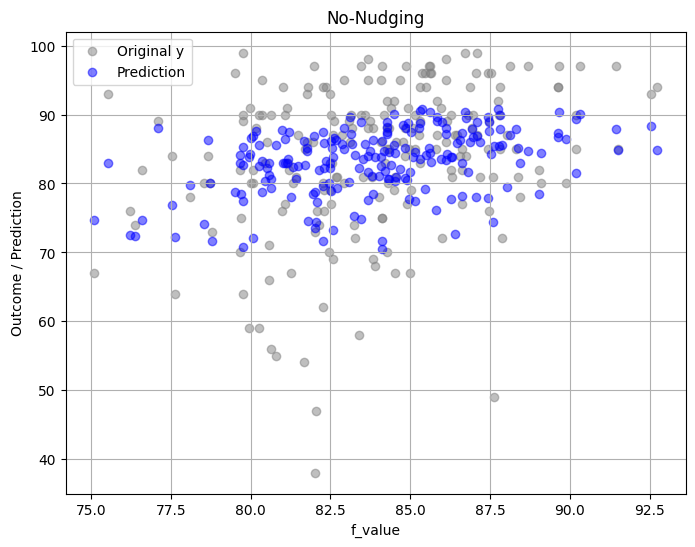

In [159]:
results_non, y_non, final_model_non, f_values_his_non, pred_history_non = no_nudging_iteration(X, y,X_states, n_rounds=1, n_splits=5, plot_each_round=True)

In [37]:
individual

[np.float64(77.463567546815),
 np.float64(81.15442464265156),
 np.float64(83.90333707780117),
 np.float64(81.80556260129315),
 np.float64(83.52023126096164),
 np.float64(80.81718480201005),
 np.float64(82.91331465600749),
 np.float64(84.23778724712427),
 np.float64(84.76365801201639),
 np.float64(86.93912748862591),
 np.float64(84.62886101004361),
 np.float64(86.11411854943046),
 np.float64(84.1931068975639),
 np.float64(86.41035007940911),
 np.float64(84.06130015225699),
 np.float64(85.46187459483208),
 np.float64(88.85949916186046),
 np.float64(85.58882766960349),
 np.float64(89.6033686000924),
 np.float64(87.77736884338434)]

In [38]:
results = pd.DataFrame(results)
results['true_mean'] = y.mean()
results

,round,cv_rmse,mean_dist_nudge,mean_dist_true,mean_current_y,mean_all_preds,true_mean
0,1,10.290201,6.094649,7.749951,83.396423,83.164804,83.892157
1,2,9.024174,5.089119,7.623414,82.815823,82.940580,83.892157
2,3,8.083195,4.474042,7.714726,82.676852,82.410055,83.892157
3,4,7.562952,4.034987,7.629962,82.548562,82.447491,83.892157
4,5,6.948017,3.681835,7.641602,82.363310,82.234113,83.892157
5,6,6.608130,3.380755,7.632718,82.253281,82.253259,83.892157
6,7,6.227629,3.105359,7.632898,82.036159,82.087722,83.892157
7,8,5.966218,2.942797,7.685369,81.933381,81.951498,83.892157
8,9,5.682531,2.621063,7.700736,81.773775,81.823473,83.892157
9,10,5.380345,2.516970,7.711071,81.507101,81.745160,83.892157


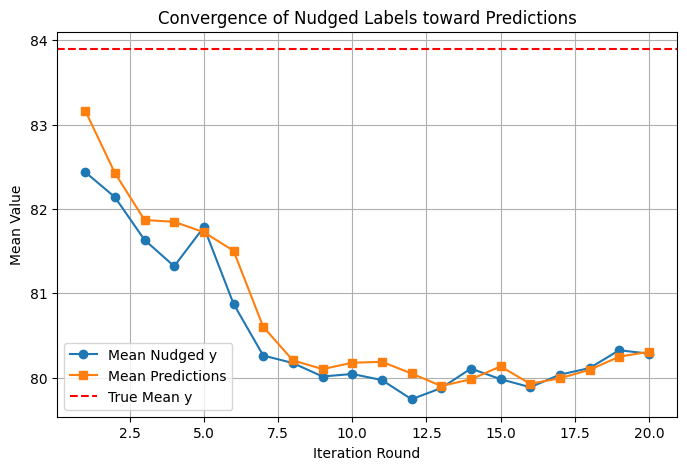

In [21]:
plt.figure(figsize=(8,5))
plt.plot(results["round"], results["mean_current_y"], marker="o", label="Mean Nudged y")
plt.plot(results["round"], results["mean_all_preds"], marker="s", label="Mean Predictions")
plt.axhline(y=results['true_mean'].iloc[0], color='r', linestyle='--', label="True Mean y")

plt.xlabel("Iteration Round")
plt.ylabel("Mean Value")
plt.title("Convergence of Nudged Labels toward Predictions")
plt.legend()
plt.grid(True)
plt.show()

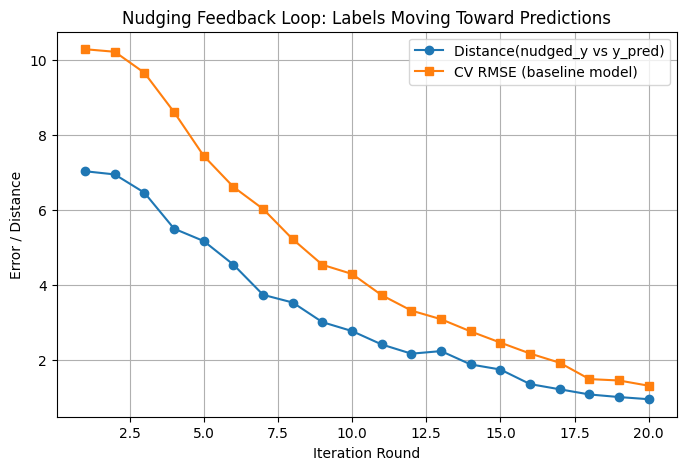

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

df_results = pd.DataFrame(results)

plt.figure(figsize=(8,5))
plt.plot(df_results["round"], df_results["mean_dist_nudge"], marker="o", label="Distance(nudged_y vs y_pred)")
plt.plot(df_results["round"], df_results["cv_rmse"], marker="s", label="CV RMSE (baseline model)")

plt.xlabel("Iteration Round")
plt.ylabel("Error / Distance")
plt.title("Nudging Feedback Loop: Labels Moving Toward Predictions")
plt.legend()
plt.grid(True)
plt.show()


In [26]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

def animate_nudging_single(y, nudged_history, pred_history, attribute, save_path=None):
    """
    Animate nudging over iterations for a single attribute.
    - y: ground truth labels
    - nudged_history: list of nudged y across iterations
    - pred_history: list of predicted y across iterations
    - attribute: DataFrame containing the single attribute used for nudging
    """
    fig, ax = plt.subplots(figsize=(7, 6))
    
    # prepare x-axis
    # attribute = attribute[attr_name].values.ravel()
    
    # calculate global ranges across all frames
    all_y_values = np.concatenate([
        np.asarray(y).ravel(),
        np.concatenate([np.asarray(p).ravel() for p in pred_history]),
        np.concatenate([np.asarray(n).ravel() for n in nudged_history])
    ])
    attribute = attribute.values.ravel().astype(float)
    
    ax.set_xlim(0, 100)
    ax.set_ylim(40, 100)
    
    # initial scatter
    scat_true  = ax.scatter(attribute, y, color="grey", alpha=0.5, label="Original y")
    scat_pred  = ax.scatter(attribute, pred_history[0], color="blue", alpha=0.5, label="Prediction")
    scat_nudge = ax.scatter(attribute, nudged_history[0], color="red", alpha=0.5, label="Nudged y")
    ax.legend()
    
    ax.set_xlabel("Test Anxiety")
    ax.set_ylabel("Score")
    ax.set_autoscale_on(False)

    # update function
    def update(frame):
        ax.set_title(f"Nudging Iteration {frame+1}")
        preds  = np.asarray(pred_history[frame]).ravel()
        nudged = np.asarray(nudged_history[frame]).ravel()
        
        scat_pred.set_offsets(np.c_[attribute, preds])
        scat_nudge.set_offsets(np.c_[attribute, nudged])
        return scat_pred, scat_nudge

    ani = animation.FuncAnimation(
        fig, update, frames=len(nudged_history), interval=1000, blit=True
    )

    if save_path:
        ani.save(save_path, writer="pillow" if save_path.endswith(".gif") else "ffmpeg")
    else:
        plt.show()


In [29]:
X_states.describe()

,Test_anxiety
count,204.000000
mean,52.720096
std,22.103296
min,3.883806
25%,37.117914
50%,54.942005
75%,67.424725
max,100.000000


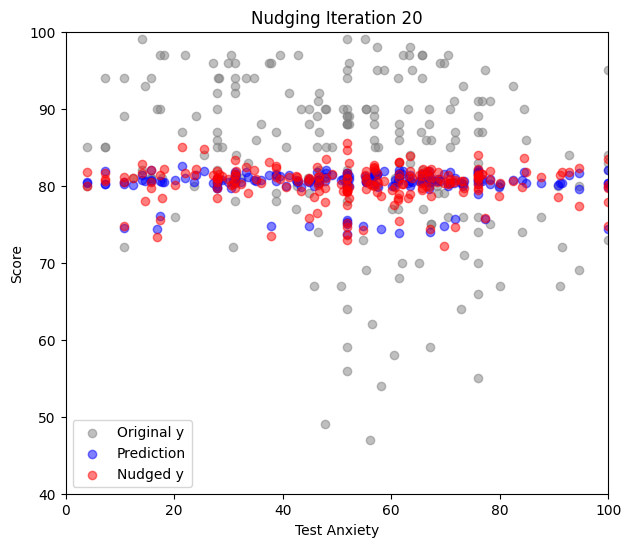

In [27]:
animate_nudging_single(y, nudged_history, pred_history, X_states, save_path="no_rule_animation.gif")

## Few Individual

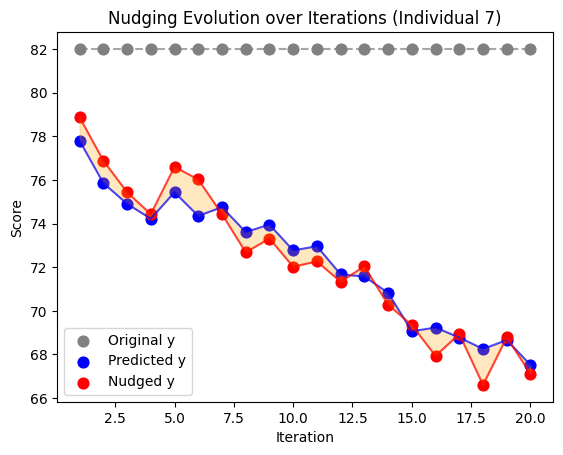

In [43]:
import matplotlib.pyplot as plt

selected_idx = 7
n_rounds = len(pred_history)
x_iter = range(1, n_rounds + 1)

# individual scores in prediction, nudged, original over iterations
orig_score = [y[selected_idx]] * n_rounds
pred_scores = [pred_history[t][selected_idx] for t in range(n_rounds)]
nudged_scores = [nudged_history[t][selected_idx] for t in range(n_rounds)]

    
# 繪圖
plt.scatter(x_iter, orig_score, color='grey', s=60, label='Original y')
plt.scatter(x_iter, pred_scores, color='blue', s=60, label='Predicted y')
plt.scatter(x_iter, nudged_scores, color='red', s=60, label='Nudged y')
plt.plot(x_iter, orig_score, color='grey', linestyle='--', alpha=0.7)
plt.plot(x_iter, pred_scores, color='blue', linestyle='-', alpha=0.7)
plt.plot(x_iter, nudged_scores, color='red', linestyle='-', alpha=0.7)

plt.fill_between(x_iter, pred_scores, nudged_scores, 
                 color='orange', alpha=0.25)

plt.xlabel("Iteration")
plt.ylabel("Score")
plt.title(f"Nudging Evolution over Iterations (Individual {selected_idx})")
plt.legend()
plt.grid(False)
plt.show()
